In [1]:
cd "Deep active contours"

[Errno 2] No such file or directory: 'Deep active contours'
/home/ahabis/3-Active_Contour_project


In [44]:
from Deep_active_contourV1 import DAC
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

filename = 'flower2.jpg'
img = plt.imread(os.path.join('unused', filename))
img = cv2.resize(img, dsize=(512,512), interpolation = cv2.INTER_AREA)

def define_contour_init():
    a, b = 256, 256
    n = 512
    r = 256

    y,x = np.ogrid[-a:n-a, -b:n-b]
    mask = x*x + y*y <= r*r

    array = np.zeros((n, n))
    array[mask] = 1
    contour_init = np.squeeze(cv2.findContours(array.astype(np.uint8),
                                 cv2.RETR_TREE,
                                 cv2.CHAIN_APPROX_SIMPLE)[0][0])
    return contour_init
contour_init = define_contour_init()
dac = DAC(nb_points = 100,
          n_epochs = 300,
          dim = 512,
          learning_rate = [5.0],
          clip = 1e-4,
          exponential_decay = 0.998,
          thresh = 1e-5)

In [45]:
contour_init = define_contour_init()

In [46]:
dac = DAC(nb_points = 200,
          n_epochs = 200,
          dim = 512,
          learning_rate = 0.1,
          clip = 1e-1,
          exponential_decay = 0.998,
          thresh = 1e-5)

In [47]:
contour, energy = dac.forward(img/255,
                              contour_init)

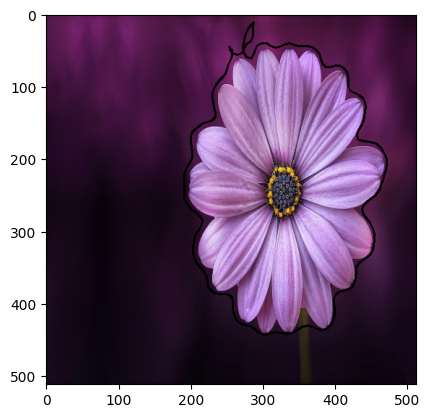

In [48]:
shape_to_display = (np.expand_dims(contour[-1], 1)).astype(int)
new_img = cv2.drawContours((((img/np.max(img))*255).astype(np.uint8)).copy(),
                        [shape_to_display],
                        0,
                        color = 1,
                        thickness=2)
plt.imshow(new_img)
plt.show()

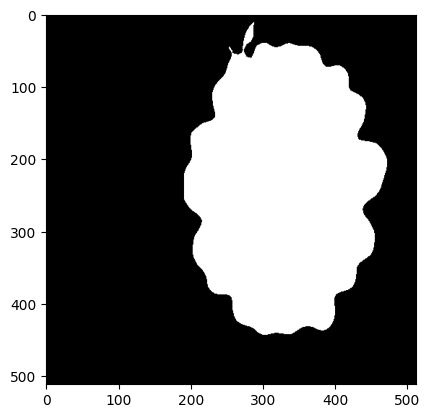

In [38]:
neros = np.zeros((512,512))
new_img = cv2.fillPoly(((neros).astype(np.uint8)).copy(),
                        [shape_to_display],
                        1)
plt.imshow(new_img, cmap ='gray')
plt.show()

In [37]:
ener = np.squeeze(energies.cpu().detach().numpy())                                                
isolines = dac.ss.cpu().detach().numpy()

for scale in range(4):
    for index, isoline in enumerate(isolines):
        
        plt.plot(np.arange(dac.n_epochs),ener[:,scale,index],label = 'isoline '+str(isoline))
    plt.title('evolution of the energies at scale: ' +str(scale+1))
    plt.xlabel('step')
    plt.ylabel('energie value')
    plt.legend()
    plt.show()

NameError: name 'energies' is not defined

In [ ]:
fig = plt.figure()

cmap = matplotlib.cm.get_cmap('seismic')

colors = [cmap(u)[:-1] for u in np.linspace(0,1,dac.n_epochs+1)]
colors = (np.array(colors)*255).astype(np.int32).tolist()



tots = []
imgs = []

for i, shape in enumerate(shape_fin[y]):

    shape_to_display = (np.expand_dims(shape, 1)).astype(int)
    
    new_img = cv2.drawContours((((img/np.max(img))*255).astype(np.uint8)).copy(),
                               [shape_to_display],
                               0,
                               color = colors[i],
                               thickness=1)
    im = plt.imshow(new_img.astype(np.uint8), animated=True)
    
    imgs.append([im])
    
ani = animation.ArtistAnimation(fig, 
                                imgs,
                                interval=50,
                                blit=False,
                                repeat_delay=1000)
plt.show()